In [17]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    PolynomialFeatures,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

Set random seed for reproducibility


In [18]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [19]:
data_path = "./data/"
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")

Using device: mps


In [7]:
seq_len = 12

# Load and prepare data


In [10]:
data = pd.read_csv(f"{data_path}rnn_data.csv")

# Create Mapping

Use mapping for location and time so we can map it back after training.


In [12]:
min_year = np.min(data["Year"].unique())
n_times = data["time_id"].nunique()
n_locations = data["location_id"].nunique()
location2idx = {location: i for i, location in enumerate(data["location_id"].unique())}
time2idx = {time: i for i, time in enumerate(data["time_id"].unique())}
data["location_idx"] = data["location_id"].map(location2idx)
data["time_idx"] = data["time_id"].map(time2idx)
data.head(5)

,location_name,location_id,Year,Month,crime_count,arrest,domestic,weekday,weekend,morning,...,morning_rate,afternoon_rate,evening_rate,night_rate,sin_month,cos_month,time_id,crime_pct_change,location_idx,time_idx
0,Abandoned/Condemned Structure,1,2018,1,20,7,1,15,5,8,...,0.400000,0.300000,0.200000,0.100000,0.000000,1.000000e+00,24217,-0.166667,0,0
1,Abandoned/Condemned Structure,1,2018,2,20,7,0,18,2,11,...,0.550000,0.200000,0.100000,0.150000,0.500000,8.660254e-01,24218,0.000000,0,1
2,Abandoned/Condemned Structure,1,2018,3,24,12,1,14,10,10,...,0.416667,0.500000,0.083333,0.000000,0.866025,5.000000e-01,24219,0.200000,0,2
3,Abandoned/Condemned Structure,1,2018,4,27,10,3,17,10,8,...,0.296296,0.592593,0.037037,0.074074,1.000000,6.123234e-17,24220,0.125000,0,3
4,Abandoned/Condemned Structure,1,2018,5,36,20,2,30,6,11,...,0.305556,0.305556,0.277778,0.111111,0.866025,-5.000000e-01,24221,0.333333,0,4


# Features used

Features required for LSTM are "crime_count", "crime_pct_change", "Year", "Month", "arrest_rate", "domestic_rate", "morning_rate", "evening_rate", "afternoon_rate", "night_rate", "num_days", "holiday_num", "sin_month", "cos_month".

LSTM does not require previous data for training in each row since we use sliding window with sequence length equal to 12.


In [15]:
features = [
    "crime_count",
    "crime_pct_change",
    "Year",
    "Month",
    "arrest_rate",
    "domestic_rate",
    "morning_rate",
    "evening_rate",
    "afternoon_rate",
    "night_rate",
    "num_days",
    "holiday_num",
    "sin_month",
    "cos_month",
]
n_features = len(features)
pivot_df = data.pivot(
    index="time_idx",
    columns="location_idx",
    values=features,
)
pivot_df = pivot_df.fillna(0)
train_size = int((len(pivot_df) - seq_len) - 12)
print(f"train_size: {train_size}")
# time_features = pd.DataFrame(index=pivot_df.index)
# time_features["holiday_num"] = data.groupby("time_idx")["holiday_count"].first()
# time_features["sin_month"] = data.groupby("time_idx")["sin_month"].first()
# time_features["cos_month"] = data.groupby("time_idx")["cos_month"].first()
pivot_df.head(5)

train_size: 60


crime_count                                                     \
location_idx          0      1     2     3     4      5      6    7      8    
time_idx                                                                      
0                   20.0  518.0  18.0  49.0  20.0  115.0  189.0  1.0  143.0   
1                   20.0  504.0  29.0  58.0  16.0  108.0  179.0  1.0  139.0   
2                   24.0  566.0  23.0  33.0  26.0  123.0  228.0  0.0  149.0   
3                   27.0  563.0  26.0  40.0  20.0  118.0  246.0  0.0  170.0   
4                   36.0  628.0  31.0  50.0  41.0  133.0  215.0  0.0  165.0   

                    ...     cos_month                                   \
location_idx    9   ...            22   23            24            25   
time_idx            ...                                                  
0             28.0  ...  0.000000e+00  0.0  1.000000e+00  1.000000e+00   
1             21.0  ...  8.660254e-01  0.0  8.660254e-01  8.660254e-01   
2             27.0  ...  5.000000e-01  0.0  5.000000e-01  5.000000e-01   
3             34.0  ...  6.123234e-17  0.0  6.123234e-17  6.123234e-17   
4             36.0  ... -5.000000e-01  0.0 -5.000000e-01 -5.000000e-01   

                                                                      \
location_idx            26            27            28            29   
time_idx                                                               
0             1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1             8.660254e-01  8.660254e-01  8.660254e-01  8.660254e-01   
2             5.000000e-01  5.000000e-01  5.000000e-01  5.000000e-01   
3             6.123234e-17  6.123234e-17  6.123234e-17  6.123234e-17   
4            -5.000000e-01 -5.000000e-01 -5.000000e-01 -5.000000e-01   

                                          
location_idx            30            31  
time_idx                                  
0             1.000000e+00  1.000000e+00  
1             8.660254e-01  8.660254e-01  
2             5.000000e-01  5.000000e-01  
3             6.123234e-17  6.123234e-17  
4            -5.000000e-01 -5.000000e-01  

[5 rows x 448 columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = pivot_df.copy()
scaler = MinMaxScaler()
print(scaled_df.shape)
scaled_df[: train_size + seq_len] = scaler.fit_transform(
    scaled_df[: train_size + seq_len]
)
scaled_df[train_size + seq_len :] = scaler.transform(scaled_df[train_size + seq_len :])
scaled_df = pd.DataFrame(scaled_df, columns=pivot_df.columns)
scaled_df

(84, 448)


crime_count                                                    \
location_idx          0         1         2         3         4         5    
time_idx                                                                     
0               0.542857  0.552102  0.326531  0.836364  0.277778  0.612613   
1               0.542857  0.526508  0.551020  1.000000  0.166667  0.549550   
2               0.657143  0.639854  0.428571  0.545455  0.444444  0.684685   
3               0.742857  0.634369  0.489796  0.672727  0.277778  0.639640   
4               1.000000  0.753199  0.591837  0.854545  0.861111  0.774775   
...                  ...       ...       ...       ...       ...       ...   
79              0.342857  0.594150  0.653061  0.036364 -0.027778  0.324324   
80              0.057143  0.524680  0.265306  0.181818  0.166667  0.423423   
81              0.400000  0.486289  0.306122  0.163636  0.055556  0.549550   
82              0.485714  0.387569  0.306122  0.254545  0.305556  0.360360   
83              0.428571  0.393053  0.367347  0.200000  0.083333  0.117117   

                                                      ... cos_month            \
location_idx        6         7         8         9   ...        22        23   
time_idx                                              ...                       
0             0.546713  0.016667  0.202247  0.619048  ...  0.500000  0.464102   
1             0.512111  0.016667  0.187266  0.452381  ...  0.933013  0.464102   
2             0.681661  0.000000  0.224719  0.595238  ...  0.750000  0.464102   
3             0.743945  0.000000  0.303371  0.761905  ...  0.500000  0.464102   
4             0.636678  0.000000  0.284644  0.809524  ...  0.250000  0.464102   
...                ...       ...       ...       ...  ...       ...       ...   
79            0.674740  0.850000  0.936330  0.428571  ...  0.066987  0.464102   
80            0.577855  0.700000  0.895131  0.309524  ...  0.250000  0.464102   
81            0.615917  0.650000  1.014981  0.452381  ...  0.500000  0.464102   
82            0.567474  0.850000  0.756554  0.214286  ...  0.500000  0.464102   
83            0.577855  0.400000  0.906367  0.309524  ...  0.500000  0.464102   

                                                                          \
location_idx        24        25        26        27        28        29   
time_idx                                                                   
0             1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1             0.933013  0.933013  0.933013  0.933013  0.933013  0.933013   
2             0.750000  0.750000  0.750000  0.750000  0.750000  0.750000   
3             0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
4             0.250000  0.250000  0.250000  0.250000  0.250000  0.250000   
...                ...       ...       ...       ...       ...       ...   
79            0.066987  0.066987  0.066987  0.066987  0.066987  0.066987   
80            0.250000  0.250000  0.250000  0.250000  0.250000  0.250000   
81            0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
82            0.750000  0.750000  0.750000  0.750000  0.750000  0.750000   
83            0.933013  0.933013  0.933013  0.933013  0.933013  0.933013   

                                  
location_idx        30        31  
time_idx                          
0             1.000000  1.000000  
1             0.933013  0.933013  
2             0.750000  0.750000  
3             0.500000  0.500000  
4             0.250000  0.250000  
...                ...       ...  
79            0.066987  0.066987  
80            0.250000  0.250000  
81            0.500000  0.500000  
82            0.750000  0.750000  
83            0.933013  0.933013  

[84 rows x 448 columns]

In [ ]:
def scale_by_feature_type(pivot_df, train_size, seq_len):
    scaled_df = pivot_df.copy()
    feature_types = pivot_df.columns.get_level_values(0).unique()
    scaler_ls = []
    for feature in feature_types:
        feature_cols = [col for col in pivot_df.columns if col[0] == feature]
        scaler = MinMaxScaler()
        feature_data = pivot_df[feature_cols]
        train_data = feature_data.iloc[: train_size + seq_len]
        scaler.fit(train_data)
        scaled_df[feature_cols] = scaler.transform(feature_data)
        scaler_ls.append(scaler)
    return scaled_df, scaler_ls


scaled_df, scaler_ls = scale_by_feature_type(pivot_df, train_size, seq_len)

In [ ]:
import numpy as np
import pandas as pd


def create_sequences(feat_df, seq_length=12):
    X_seq = []
    y_vals = []
    loc_idx = []
    time_idx = []
    T = feat_df.shape[0]
    locations = feat_df.columns.get_level_values(1).unique()
    crime_feature = feat_df.columns.get_level_values(0)[
        0
    ]  # Assuming 'crime_count' is the first feature type
    for location in locations:
        location_data = feat_df.xs(location, axis=1, level=1)

        # Create sliding windows
        for i in range(T - seq_length):
            # Extract feature window for all features
            feature_window = location_data.iloc[
                i : i + seq_length
            ].values  # shape (seq_length, n_features)
            y_val = feat_df[(crime_feature, location)].iloc[i + seq_length]
            X_seq.append(feature_window)
            y_vals.append(y_val)
            loc_idx.append(location)
            time_idx.append(i)
    X_seq = np.array(X_seq)  # shape => (n_locations * n_times, seq_length, n_features)
    y_vals = np.array(y_vals)  # shape => (n_locations * n_times,)
    loc_idx = np.array(loc_idx)  # shape => (n_locations * n_times,)
    time_idx = np.array(time_idx)  # shape => (n_locations * n_times,)
    return X_seq, y_vals, loc_idx, time_idx


seq_length = 12
X_seq, y, loc_idx, time_idx = create_sequences(scaled_df, seq_length=seq_length)

print("X_seq shape:", X_seq.shape)  # (n_locations * n_times, seq_length, n_features)
print("y shape:", y.shape)  # (n_locations * n_times,)
print("loc_idx shape:", loc_idx.shape)  # (n_locations * n_times,)
print("time_idx shape:", time_idx.shape)  # (n_locations * n_times,)

X_seq shape: (2304, 12, 14)
y shape: (2304,)
loc_idx shape: (2304,)
time_idx shape: (2304,)


In [ ]:
train_mask = time_idx < train_size
test_mask = time_idx >= train_size

X_train = X_seq[train_mask]
y_train = y[train_mask]
loc_train = loc_idx[train_mask]
time_train = time_idx[train_mask]

X_test = X_seq[test_mask]
y_test = y[test_mask]
loc_test = loc_idx[test_mask]
time_test = time_idx[test_mask]

print("Train shapes:", X_train.shape, y_train.shape, loc_train.shape, time_train.shape)
print("Test shapes:", X_test.shape, y_test.shape, loc_test.shape, time_test.shape)

Train shapes: (1920, 12, 14) (1920,) (1920,) (1920,)
Test shapes: (384, 12, 14) (384,) (384,) (384,)


In [ ]:
from torch.utils.data import Dataset, DataLoader


class CrimeDataset(Dataset):
    def __init__(self, X, y, loc_idx, time_idx):
        self.X = X  # n_sequences, seq_len, n_location
        self.y = y  # n_sequences, n_location
        self.loc_idx = loc_idx
        self.time_idx = time_idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        loc_idx = torch.tensor(self.loc_idx[idx], dtype=torch.long)
        time_idx = torch.tensor(self.time_idx[idx], dtype=torch.long)
        return X, y, loc_idx, time_idx

In [ ]:
num_size = n_features
cat_size = n_locations
batch_size = 32
hidden_size = 128
num_layers = 3
embed_dim = 16
output_size = 1
num_epochs = 100
dropout = 0.5

In [ ]:
train_dataset = CrimeDataset(X_train, y_train, loc_train, time_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CrimeDataset(X_test, y_test, loc_test, time_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for X_batch, y_batch, loc_batch, time_batch in train_loader:
    print(f"X_batch shape: {X_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    print(f"loc_batch shape: {loc_batch.shape}")
    print(f"time_batch shape: {time_batch.shape}")
    break

X_batch shape: torch.Size([32, 12, 14])
y_batch shape: torch.Size([32])
loc_batch shape: torch.Size([32])
time_batch shape: torch.Size([32])


In [ ]:
class CrimeLSTM(nn.Module):
    def __init__(
        self,
        num_size,
        cat_size,
        hidden_size,
        embed_dim,
        num_layers,
        output_size,
        dropout,
    ):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(cat_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=num_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, X, loc, h_0, c_0):
        """
        x: [batch_size, seq_len, n_feature]
        h_0, c_0: [num_layers, batch_size, hidden_size]
        output: [batch_size, n_location, output_size]
        """
        _, seq_len, _ = X.shape
        loc_embed = self.embedding(loc)
        loc_embed = loc_embed.unsqueeze(1).repeat(1, seq_len, 1)
        lstm_input = torch.cat((X, loc_embed), dim=2)
        lstm_output, (h_n, c_n) = self.lstm(lstm_input, (h_0, c_0))
        last_output = lstm_output[:, -1, :]
        fc_out = self.fc1(last_output)
        fc_out = self.relu(fc_out)
        fc_out = self.dropout(fc_out)
        fc_out = self.fc2(fc_out)  # [batch_size*n_location, output_size]
        return fc_out, (h_n, c_n)

In [ ]:
model = CrimeLSTM(
    num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout
).to(device)
print(model)

CrimeLSTM(
  (embedding): Embedding(32, 16)
  (lstm): LSTM(30, 128, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Define loss function and optimizer


In [ ]:
criterion = nn.MSELoss()

Training function


In [ ]:
# Validation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for X_batch, y_batch, loc_batch, _ in test_loader:
            X_batch, y_batch, loc_batch = (
                X_batch.to(device),
                y_batch.to(device),
                loc_batch.to(device),
            )
            curr_batch_size = X_batch.shape[0]
            h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            score, (_, _) = model(X_batch, loc_batch, h, c)
            score = score.view(curr_batch_size)
            loss = criterion(score, y_batch)
            val_loss += loss.item()
            num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [ ]:
start_time = time.time()
train_losses = []
val_losses = []
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",  # because we're monitoring loss
    factor=0.5,  # how much to reduce the LR
    patience=5,  # how many epochs to wait
    threshold=1e-4,  # min improvement to be considered
    cooldown=0,  # cooldown after reduction
    min_lr=1e-6,  # don’t go below this
)
best_val_loss = float("inf")
best_model_path = "./model/best_lstm_model.pth"
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    for X_batch, y_batch, loc_batch, _ in train_loader:
        optimizer.zero_grad()
        curr_batch_size = X_batch.shape[0]
        X_batch, y_batch, loc_batch = (
            X_batch.to(device),
            y_batch.to(device),
            loc_batch.to(device),
        )
        h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        score, (_, _) = model(X_batch, loc_batch, h, c)
        score = score.reshape(curr_batch_size)
        loss = criterion(score, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, test_loader, criterion)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved in {best_model_path} with validation loss: {val_loss:.12f}")
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, LR: {scheduler.get_last_lr()[0]:.12f}"
    )

Model saved in ./model/best_lstm_model.pth with validation loss: 0.647863087555
Epoch [1/100], Train Loss: 0.070704240414, Val Loss: 0.647863087555, LR: 0.001000000000
Model saved in ./model/best_lstm_model.pth with validation loss: 0.624447511043
Epoch [2/100], Train Loss: 0.049031902881, Val Loss: 0.624447511043, LR: 0.001000000000
Model saved in ./model/best_lstm_model.pth with validation loss: 0.589080568170
Epoch [3/100], Train Loss: 0.044031501344, Val Loss: 0.589080568170, LR: 0.001000000000
Model saved in ./model/best_lstm_model.pth with validation loss: 0.551936922595
Epoch [4/100], Train Loss: 0.038163118313, Val Loss: 0.551936922595, LR: 0.001000000000
Model saved in ./model/best_lstm_model.pth with validation loss: 0.526762281234
Epoch [5/100], Train Loss: 0.035899883322, Val Loss: 0.526762281234, LR: 0.001000000000
Model saved in ./model/best_lstm_model.pth with validation loss: 0.507740117687
Epoch [6/100], Train Loss: 0.033469086544, Val Loss: 0.507740117687, LR: 0.00100

Train the model


Plot training and validation loss


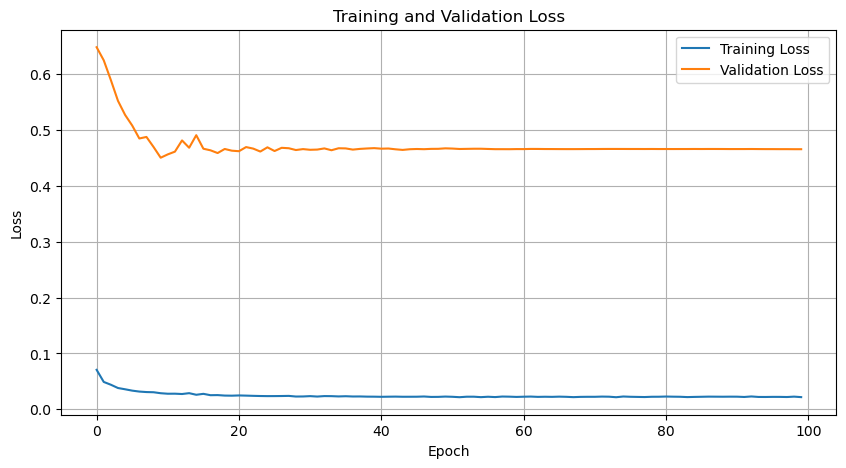

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("./figure/training_validation_loss.pdf", format="pdf")
plt.show()

In [ ]:
def predictions(model, train_loader, test_loader):
    result = np.zeros(
        (
            (len(train_loader.dataset) + len(test_loader.dataset)) // n_locations,
            n_locations,
            2,
        )
    )

    def get_result(result, loader):
        model.eval()
        with torch.no_grad():
            for i, (X_batch, y_batch, loc_batch, time_batch) in enumerate(loader):
                curr_batch_size = X_batch.shape[0]
                X_batch, y_batch, loc_batch = (
                    X_batch.to(device),
                    y_batch.to(device),
                    loc_batch.to(device),
                )
                h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                score, (_, _) = model(X_batch, loc_batch, h, c)
                score = score.reshape(curr_batch_size)
                result[time_batch, loc_batch.cpu().numpy(), 0] = score.cpu().numpy()
                result[time_batch, loc_batch.cpu().numpy(), 1] = y_batch.cpu().numpy()

    get_result(result, train_loader)
    get_result(result, test_loader)
    return result

In [ ]:
pred_model = CrimeLSTM(
    num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout
).to(device)
pred_model.load_state_dict(torch.load(best_model_path))
result = predictions(model, train_loader, test_loader)
result_unscaled = np.zeros(result.shape)
result_unscaled[:, :, 0] = scaler_ls[0].inverse_transform(result[:, :, 0])
result_unscaled[:, :, 1] = scaler_ls[0].inverse_transform(result[:, :, 1])
result_unscaled = np.round(result_unscaled).astype(int)
result_df = data.copy()
result_df["lstm_pred"] = np.nan
for i in range(len(result_unscaled)):
    for j in range(len(result_unscaled[i])):
        result_df.loc[
            (result_df["time_idx"] == i + seq_length)
            & (result_df["location_idx"] == j),
            "lstm_pred",
        ] = result_unscaled[i, j, 0]

/var/folders/sx/pmvfmfnd1yb2twxrjn65_p0m0000gn/T/ipykernel_83186/2353286371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred_model.load_state_dict(torch.load(best_mo

In [ ]:
result_df = result_df[result_df["time_idx"] > seq_length - 1]
result_df.to_csv("./data/lstm_predictions.csv", index=False)

In [ ]:
result_df[
    [
        "Year",
        "Month",
        "location_id",
        "time_id",
        "time_idx",
        "location_idx",
        "crime_count",
        "lstm_pred",
    ]
].head(12)

,Year,Month,location_id,time_id,time_idx,location_idx,crime_count,lstm_pred
12,2019,1,1,24229,12,0,27,20.0
13,2019,2,1,24230,13,0,10,18.0
14,2019,3,1,24231,14,0,11,16.0
15,2019,4,1,24232,15,0,20,15.0
16,2019,5,1,24233,16,0,27,19.0
17,2019,6,1,24234,17,0,22,24.0
18,2019,7,1,24235,18,0,29,26.0
19,2019,8,1,24236,19,0,27,27.0
20,2019,9,1,24237,20,0,28,24.0
21,2019,10,1,24238,21,0,32,23.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [ ]:
def weighted_mape(y_true, y_pred):
    """Calculate Weighted Mean Absolute Percentage Error"""
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100


y_true = result_df["crime_count"].values
y_pred = result_df["lstm_pred"].values
y_train_true = result_df[result_df["time_idx"] < train_size + seq_len]["crime_count"]
y_train_pred = result_df[result_df["time_idx"] < train_size + seq_len]["lstm_pred"]
y_test_true = result_df[result_df["time_idx"] >= train_size + seq_len]["crime_count"]
y_test_pred = result_df[result_df["time_idx"] >= train_size + seq_len]["lstm_pred"]
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_test = mean_absolute_error(y_test_true, y_test_pred)
rmse_train = root_mean_squared_error(y_train_true, y_train_pred)
rmse_test = root_mean_squared_error(y_test_true, y_test_pred)
r2_train = r2_score(y_train_true, y_train_pred)
r2_test = r2_score(y_test_true, y_test_pred)
train_mean_value = np.mean(y_train_true)
test_mean_value = np.mean(y_test_true)
wmae_train = weighted_mape(y_train_true, y_train_pred)
wmae_test = weighted_mape(y_test_true, y_test_pred)

print(
    f"Train MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}, Weighted MAE Percentage: {wmae_train:.4f}%"
)
print(
    f"Test MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}, Normalized MAE Percentage: {wmae_test:.4f}%"
)

Train MAE: 43.2520, RMSE: 119.3986, R2: 0.9956, Weighted MAE Percentage: 6.3233%
Test MAE: 46.6977, RMSE: 135.9026, R2: 0.9947, Normalized MAE Percentage: 6.4223%


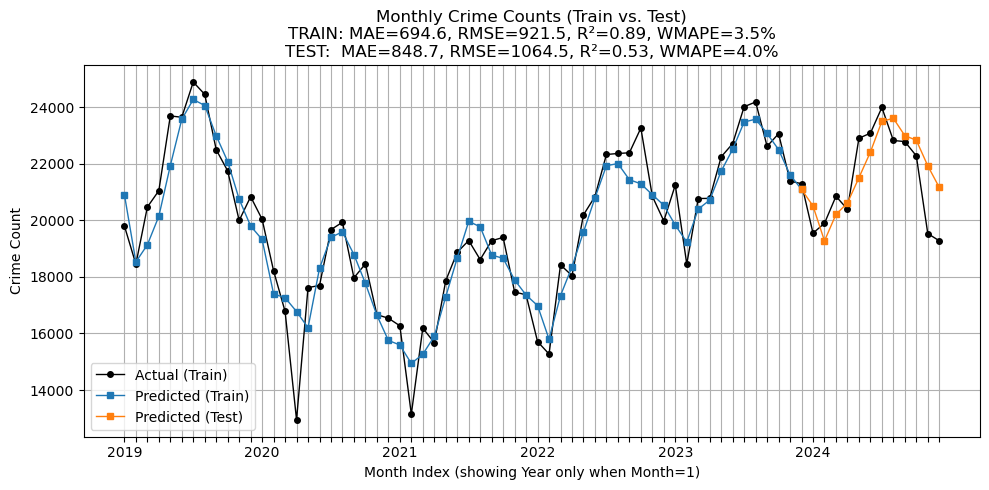

In [ ]:
monthly_agg = result_df.groupby(["Year", "Month"], as_index=False).agg(
    {"crime_count": "sum", "lstm_pred": "sum"}
)

monthly_agg.sort_values(["Year", "Month"], inplace=True)

y_true = monthly_agg["crime_count"].values
y_pred = monthly_agg["lstm_pred"].values

x_vals = np.arange(len(monthly_agg))

cutoff = train_size
train_mask = x_vals < cutoff
test_mask = x_vals >= cutoff - 1
y_true_train, y_pred_train = y_true[train_mask], y_pred[train_mask]
y_true_test, y_pred_test = y_true[test_mask], y_pred[test_mask]

mae_train = mean_absolute_error(y_true_train, y_pred_train)
rmse_train = root_mean_squared_error(y_true_train, y_pred_train)
r2_train = r2_score(y_true_train, y_pred_train)
mape_train = weighted_mape(y_true_train, y_pred_train)

mae_test = mean_absolute_error(y_true_test, y_pred_test)
rmse_test = root_mean_squared_error(y_true_test, y_pred_test)
r2_test = r2_score(y_true_test, y_pred_test)
mape_test = weighted_mape(y_true_test, y_pred_test)
labels = []
for _, row in monthly_agg.iterrows():
    year = row["Year"]
    month = row["Month"]
    if month == 1:
        labels.append(int(year))  # show the year for January
    else:
        labels.append("")  # show empty for other months
plt.figure(figsize=(10, 5))

# Actual - Train portion
plt.plot(
    x_vals,
    y_true,
    marker="o",
    label="Actual (Train)",
    color="black",
    markersize=4,
    linewidth=1,
)
plt.plot(
    x_vals[train_mask],
    y_pred[train_mask],
    marker="s",
    label="Predicted (Train)",
    markersize=4,
    linewidth=1,
)
plt.plot(
    x_vals[test_mask],
    y_pred[test_mask],
    marker="s",
    label="Predicted (Test)",
    linestyle="-",
    markersize=4,
    linewidth=1,
)

plt.title(
    "Monthly Crime Counts (Train vs. Test)\n"
    "TRAIN: "
    f"MAE={mae_train:.1f}, RMSE={rmse_train:.1f}, R²={r2_train:.2f}, WMAPE={mape_train:.1f}%\n"
    "TEST:  "
    f"MAE={mae_test:.1f}, RMSE={rmse_test:.1f}, R²={r2_test:.2f}, WMAPE={mape_test:.1f}%"
)

plt.xlabel("Month Index (showing Year only when Month=1)")
plt.ylabel("Crime Count")
plt.xticks(x_vals, labels, rotation=0)  # Use custom labels
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
result_df[["location_id", "location_name"]]
idx2location = pd.Series(
    result_df["location_name"].unique(), index=result_df["location_idx"].unique()
).to_dict()

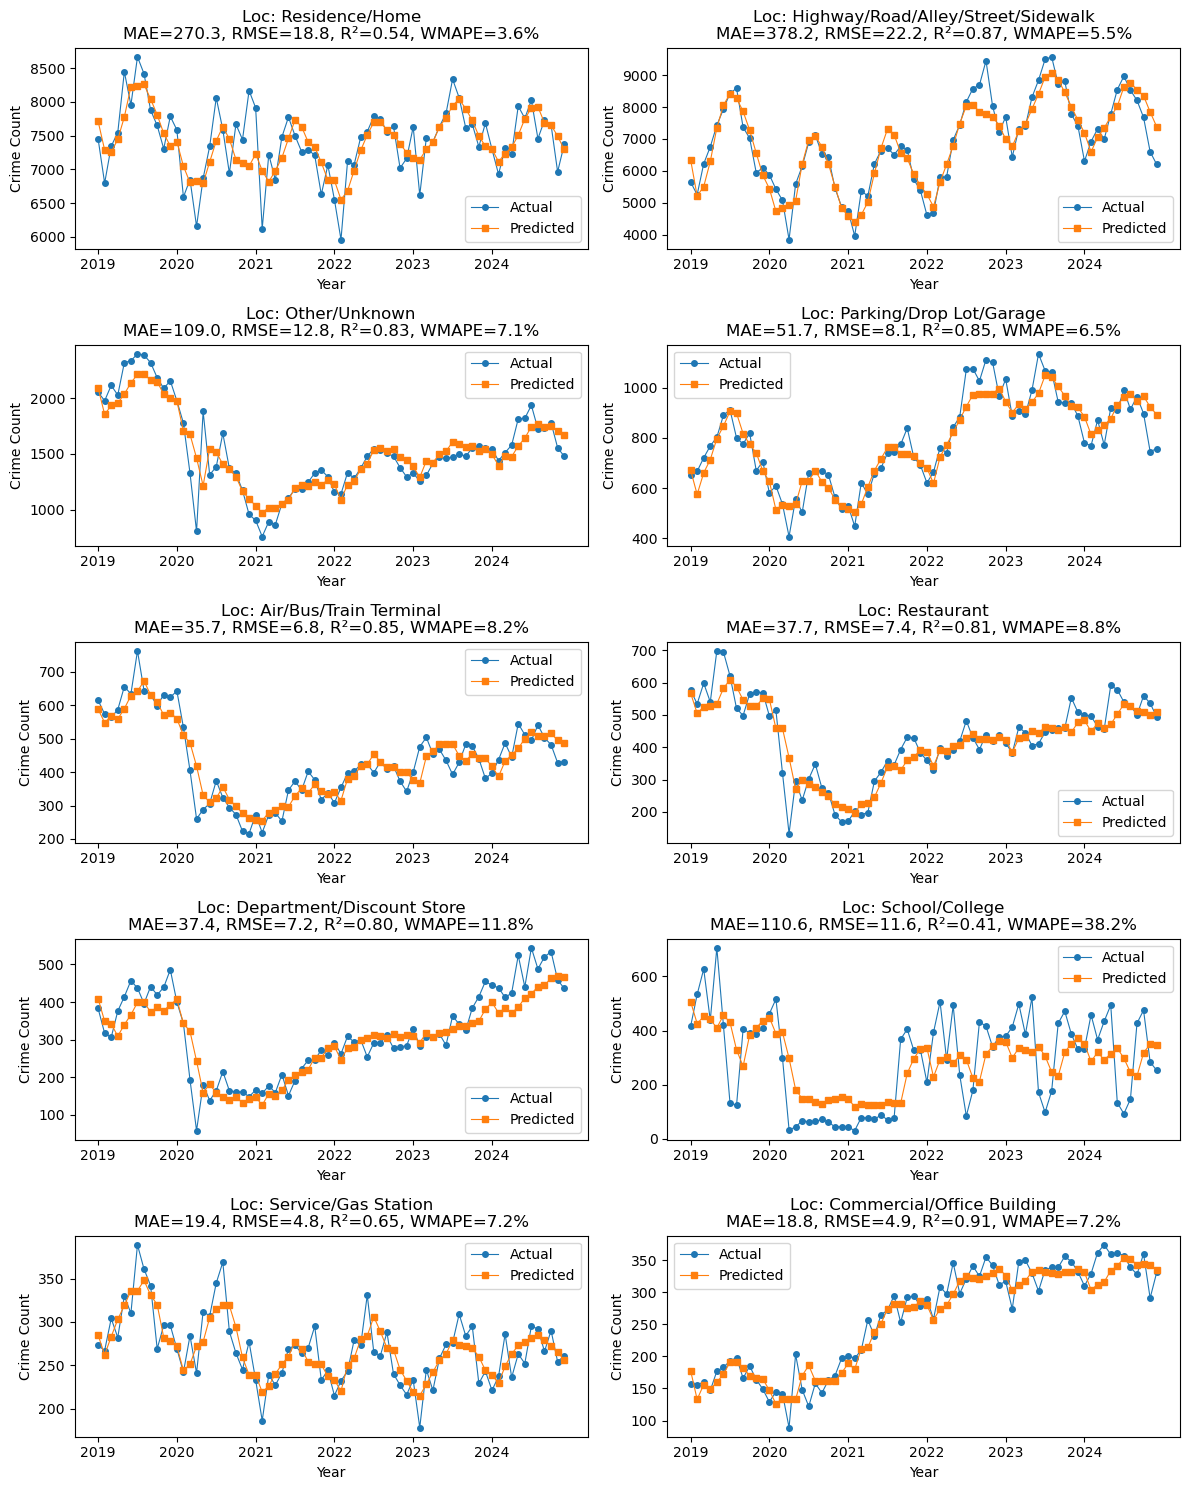

In [ ]:
df = result_df.copy()
df.sort_values(["location_idx", "Year", "Month"], inplace=True)
total_by_loc = (
    df.groupby("location_idx")["crime_count"].sum().sort_values(ascending=False)
)
top_locations = total_by_loc.index[:10]
df_top = df[df["location_idx"].isin(top_locations)].copy()
df_top.sort_values(["location_idx", "Year", "Month"], inplace=True)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
axes = axes.flatten()
for i, loc in enumerate(top_locations):
    df_loc = df_top[df_top["location_idx"] == loc].copy()
    df_loc.sort_values(["Year", "Month"], inplace=True)
    df_loc.reset_index(drop=True, inplace=True)  # reset index so x-axis is 0, 1, 2, ...
    x_vals = df_loc.index  # Each index represents one month
    actual = df_loc["crime_count"].values
    predicted = df_loc["lstm_pred"].values
    mae_val = mean_absolute_error(actual, predicted)
    rmse_val = np.sqrt(root_mean_squared_error(actual, predicted))
    r2_val = r2_score(actual, predicted)
    wmape = weighted_mape(actual, predicted)
    ax = axes[i]
    ax.plot(x_vals, actual, marker="o", markersize=4, linewidth=0.8, label="Actual")
    ax.plot(
        x_vals, predicted, marker="s", markersize=4, linewidth=0.8, label="Predicted"
    )
    ax.set_title(
        f"Loc: {idx2location[loc]}\nMAE={mae_val:.1f}, RMSE={rmse_val:.1f}, R²={r2_val:.2f}, WMAPE={wmape:.1f}%"
    )
    ax.set_xlabel("Year")
    ax.set_ylabel("Crime Count")
    unique_years = df_loc["Year"].unique()
    tick_positions = []
    tick_labels = []
    for year in unique_years:
        pos = df_loc[df_loc["Year"] == year].index[0]
        tick_positions.append(pos)
        tick_labels.append(str(year))
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.legend()

plt.tight_layout()
plt.show()

In [64]:
import pandas as pd
import numpy as np

data_path = "data/"

In [65]:
df = pd.read_csv(data_path + "time_series_data.csv")
df_train = df[df["Year"] <= 2023]
df_test = df[df["Year"] > 2023]
"num_days" in df_train.columns

True

In [67]:
categorical_cols = ["location_name"]
numerical_cols = ["sin_month", "cos_month", "Year", "Month", "num_days", "holiday_num"]
numerical_features = [
    "crime_count",
    "crime_pct_change",
    "morning",
    "afternoon",
    "evening",
    "night",
    "domestic",
    "arrest",
]
for i in [1, 2, 3, 6, 12]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_lag{i}")
for i in [3, 6]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_ma{i}")

# Split features and target
X_train = df_train[categorical_cols + numerical_cols]
y_train = df_train["crime_count"]
X_test = df_test[categorical_cols + numerical_cols]
y_test = df_test["crime_count"]

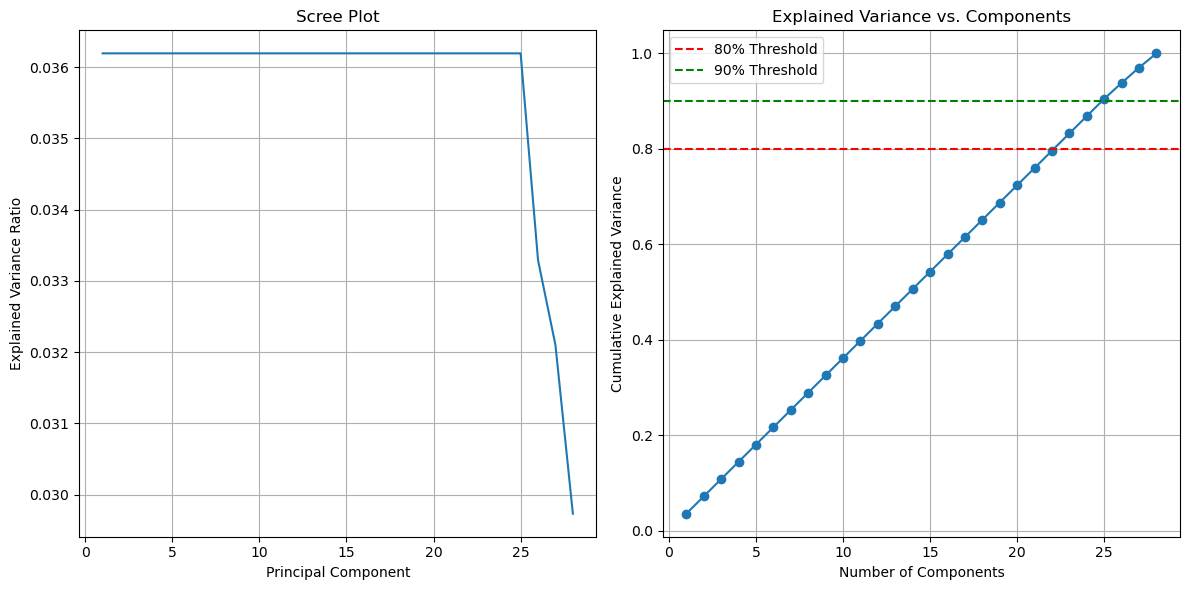

In [68]:
from sklearn.decomposition import PCA

ohc = OneHotEncoder(handle_unknown="ignore")
X_coded = ohc.fit_transform(X_train[categorical_cols])
pca = PCA(n_components=X_coded.shape[1] - 1, random_state=42)
pca_result = pca.fit_transform(X_coded)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_
)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)

# Plot the cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker="o",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Components")
plt.axhline(y=0.8, color="r", linestyle="--", label="80% Threshold")
plt.axhline(y=0.9, color="g", linestyle="--", label="90% Threshold")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
cat_pipe = Pipeline(
    [
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat_pipe", cat_pipe, categorical_cols),
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())],
)

In [70]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['sin_month', 'cos_month',
                                                   'Year', 'Month', 'num_days',
                                                   'holiday_num',
                                                   'crime_count_lag1',
                                                   'crime_pct_change_lag1',
                                                   'morning_lag1',
                                                   'afternoon_lag1',
                                                   'evening_lag1', 'night_lag1',
                                                   'domestic_lag1',
                                                   'arrest_lag1',
                                                   'crime_count_lag2',
                                                   'crime_pct_change_lag2',
                                                   'morning_lag2',
                                                   'afternoon_lag2',
                                                   'evening_lag2', 'night_lag2',
                                                   'domestic_lag2',
                                                   'arrest_lag2',
                                                   'crime_count_lag3',
                                                   'crime_pct_change_lag3',
                                                   'morning_lag3',
                                                   'afternoon_lag3',
                                                   'evening_lag3', 'night_lag3',
                                                   'domestic_lag3',
                                                   'arrest_lag3', ...]),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['location_name'])])),
                ('regressor', LinearRegression())])

In [71]:
lr_train_pred = model.predict(X_train)
lr_pred = model.predict(X_test)
lr_train_pred = np.round(lr_train_pred)
lr_pred = np.round(lr_pred)

In [72]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Calculate regression metrics
rmse = root_mean_squared_error(y_test, lr_pred)
mae = mean_absolute_error(y_test, lr_pred)
r2 = r2_score(y_test, lr_pred)
mean_value = y_test.mean()
print(mean_value)
mae_percentage = (mae / mean_value) * 100

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {mae_percentage:.2f}%")

743.8265895953757
Root Mean Squared Error: 132.99
Mean Absolute Error: 56.13
R² Score: 0.99
Normalized Mean Absolute Error Percentage: 7.55%


# Random Forest Regressor


In [73]:
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [74]:
from sklearn.ensemble import RandomForestRegressor

# Same preprocessing pipeline, but switch out the regressor
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree),
        ("regressor", RandomForestRegressor(n_estimators=100, random_state=42)),
    ]
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_pred = rf_model.predict(X_test)
rf_train_pred = np.round(rf_train_pred)
rf_pred = np.round(rf_pred)

In [75]:
# Evaluate the model
rf_rmse = root_mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae_percentage = (rf_mae / y_test.mean()) * 100

print(f"Random Forest Results:")
print(f"Root Mean Squared Error: {rf_rmse:.2f}")
print(f"Mean Absolute Error: {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {rf_mae_percentage:.2f}%")

Random Forest Results:
Root Mean Squared Error: 157.01
Mean Absolute Error: 53.29
R² Score: 0.99
Normalized Mean Absolute Error Percentage: 7.16%


In [76]:
from xgboost import XGBRegressor

xg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree),
        (
            "regressor",
            XGBRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=7,
                gamma=0.1,
                random_state=42,
            ),
        ),
    ]
)
xg_model.fit(X_train, y_train)
xg_train_pred = xg_model.predict(X_train)
xg_pred = xg_model.predict(X_test)
xg_train_pred = np.round(xg_train_pred)
xg_pred = np.round(xg_pred)

In [77]:
# Evaluate the model
xg_rmse = root_mean_squared_error(y_test, xg_pred)
xg_mae = mean_absolute_error(y_test, xg_pred)
xg_r2 = r2_score(y_test, xg_pred)
xg_mae_percentage = (xg_mae / y_test.mean()) * 100
print(f"XGBoost Results:")
print(f"Root Mean Squared Error: {xg_rmse:.2f}")
print(f"Mean Absolute Error: {xg_mae:.2f}")
print(f"R² Score: {xg_r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {xg_mae_percentage:.2f}%")

XGBoost Results:
Root Mean Squared Error: 139.71
Mean Absolute Error: 50.88
R² Score: 0.99
Normalized Mean Absolute Error Percentage: 6.84%


In [78]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    "regressor__n_estimators": [200],
    "regressor__learning_rate": [0.1],
    "regressor__max_depth": [5],
    "regressor__min_child_weight": [5],
    "regressor__gamma": [0.1],
}

# Create the pipeline with XGBRegressor
xg_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor(random_state=42))]
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_squared_error",
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Display progress
)

# Fit the grid search to the data
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed!")

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best parameters: {best_params}")

# Evaluate the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Training metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Testing metrics
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing R²: {test_r2:.4f}")

# Store residuals for plotting
xg_res = y_test - y_test_pred

Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Grid search completed!
Best parameters: {'regressor__gamma': 0.1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 200}

Model Performance:
Training RMSE: 12.7458
Training R²: 1.0000
Testing RMSE: 127.1771
Testing R²: 0.9954


In [79]:
df_train_result = df_train.copy()
df_test_result = df_test.copy()
df_lstm = pd.read_csv(data_path + "lstm_predictions.csv")
df_lstm[["location_id", "crime_count", "lstm_pred", "time_id"]]
df_train_lstm = df_lstm[df_lstm["Year"] <= 2023]
df_test_lstm = df_lstm[df_lstm["Year"] > 2023]
df_train_result = df_train_result.merge(
    df_train_lstm[["location_id", "time_id", "lstm_pred"]],
    on=["location_id", "time_id"],
    how="left",
)
df_test_result = df_test_result.merge(
    df_test_lstm[["location_id", "time_id", "lstm_pred"]],
    on=["location_id", "time_id"],
    how="left",
)
df_train_result["lr_pred"] = lr_train_pred
df_train_result["rf_pred"] = rf_train_pred
df_train_result["xg_pred"] = xg_train_pred
df_test_result["lr_pred"] = lr_pred
df_test_result["rf_pred"] = rf_pred
df_test_result["xg_pred"] = xg_pred
df_train_result["lstm_pred"] = df_train_result["lstm_pred"]
df_test_result["lstm_pred"] = df_test_result["lstm_pred"]


# Add residuals (actual - predicted)
df_train_result["lr_res"] = df_train_result["crime_count"] - df_train_result["lr_pred"]
df_train_result["rf_res"] = df_train_result["crime_count"] - df_train_result["rf_pred"]
df_train_result["xg_res"] = df_train_result["crime_count"] - df_train_result["xg_pred"]
df_train_result["lstm_res"] = (
    df_train_result["crime_count"] - df_train_result["lstm_pred"]
)
df_test_result["lr_res"] = df_test_result["crime_count"] - df_test_result["lr_pred"]
df_test_result["rf_res"] = df_test_result["crime_count"] - df_test_result["rf_pred"]
df_test_result["xg_res"] = df_test_result["crime_count"] - df_test_result["xg_pred"]
df_test_result["lstm_res"] = df_test_result["crime_count"] - df_test_result["lstm_pred"]
df_test_result[
    ["time_id", "location_id", "crime_count", "xg_pred", "lr_pred", "rf_pred"]
]
df_train_result

,location_name,location_id,Year,Month,crime_count,arrest,domestic,weekday,weekend,morning,...,evening_ma6,night_ma6,lstm_pred,lr_pred,rf_pred,xg_pred,lr_res,rf_res,xg_res,lstm_res
0,Abandoned/Condemned Structure,1,2019,1,27,15,0,24,3,16,...,4.333333,3.833333,20.0,38.0,25.0,23.0,-11.0,2.0,4.0,7.0
1,Air/Bus/Train Terminal,2,2019,1,615,148,11,482,133,125,...,125.333333,108.666667,589.0,576.0,594.0,594.0,39.0,21.0,21.0,26.0
2,Arena/Stadium/Fairgrounds/Coliseum,4,2019,1,30,3,0,19,11,5,...,18.666667,4.666667,37.0,47.0,33.0,39.0,-17.0,-3.0,-9.0,-7.0
3,ATM Separate from Bank,5,2019,1,25,2,0,21,4,9,...,4.666667,8.166667,29.0,53.0,23.0,21.0,-28.0,2.0,4.0,-4.0
4,Auto Dealership New/Used,6,2019,1,18,1,2,15,3,8,...,5.666667,4.500000,20.0,57.0,18.0,17.0,-39.0,0.0,1.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,Restaurant,37,2023,12,508,48,23,306,202,80,...,107.166667,99.666667,477.0,497.0,491.0,513.0,11.0,17.0,-5.0,31.0
1713,School/College,38,2023,12,331,18,14,314,17,141,...,14.000000,16.500000,373.0,334.0,379.0,355.0,-3.0,-48.0,-24.0,-42.0
1714,Service/Gas Station,41,2023,12,243,40,7,162,81,63,...,71.833333,88.166667,244.0,240.0,245.0,244.0,3.0,-2.0,-1.0,-1.0
1715,Other/Unknown,98,2023,12,1555,187,87,1065,490,405,...,312.166667,245.833333,1546.0,1518.0,1535.0,1520.0,37.0,20.0,35.0,9.0


In [80]:
# summarize the results (metrics)
def summarize_results(df, model):
    rmse = root_mean_squared_error(df["crime_count"], df[model])
    mae = mean_absolute_error(df["crime_count"], df[model])
    r2 = r2_score(df["crime_count"], df[model])
    mean_value = df["crime_count"].mean()
    mae_percentage = (mae / mean_value) * 100
    return rmse, mae, r2, mae_percentage


for m in ["lr", "rf", "xg", "lstm"]:
    rmse, mae, r2, mae_percentage = summarize_results(df_test_result, f"{m}_pred")
    print(f"Model: {m}")
    print(f"RMSE\tR²\tMAE\tMAE Percentage")
    print(f"{rmse:.2f}\t{r2:.2f}\t{mae:.2f}\t{mae_percentage:.2f}%")
    print("\n")

Model: lr
RMSE	R²	MAE	MAE Percentage
132.99	0.99	56.13	7.55%


Model: rf
RMSE	R²	MAE	MAE Percentage
157.01	0.99	53.29	7.16%


Model: xg
RMSE	R²	MAE	MAE Percentage
139.71	0.99	50.88	6.84%


Model: lstm
RMSE	R²	MAE	MAE Percentage
137.48	0.99	47.70	6.41%




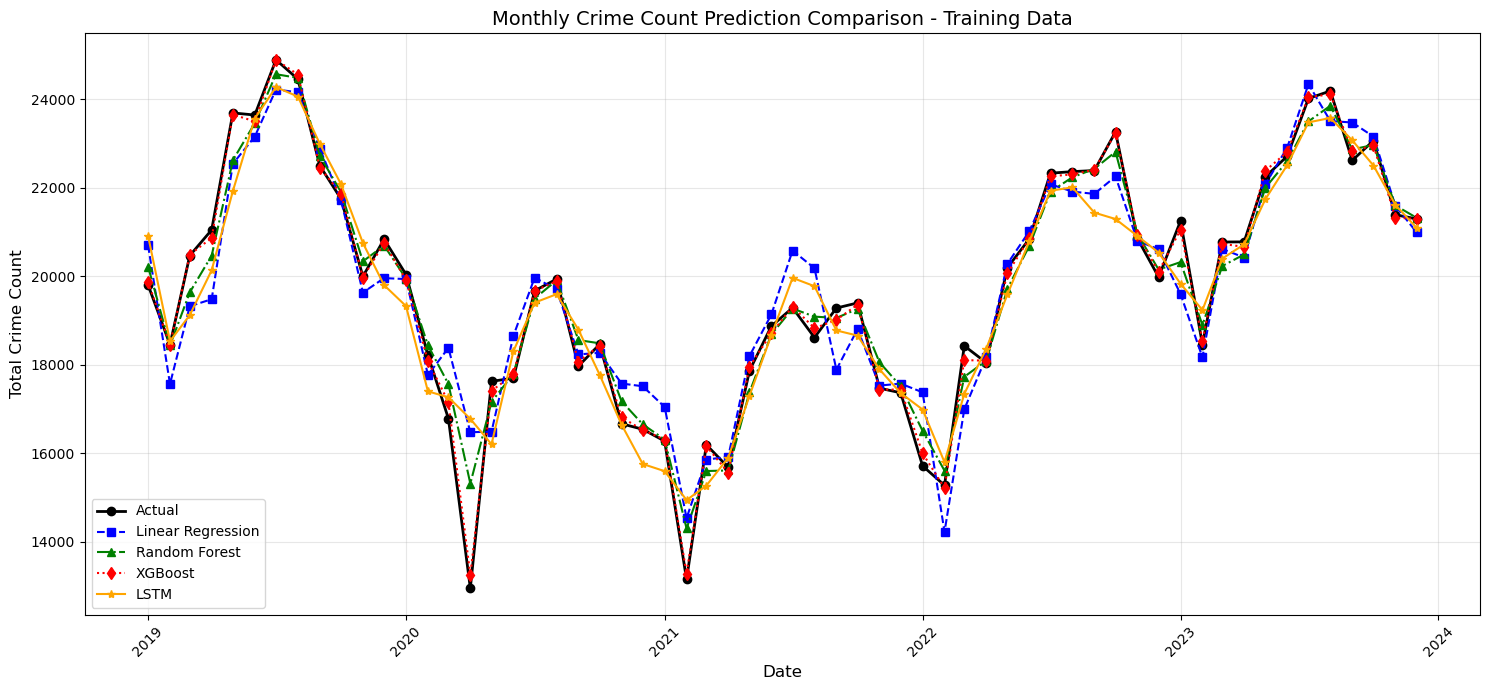

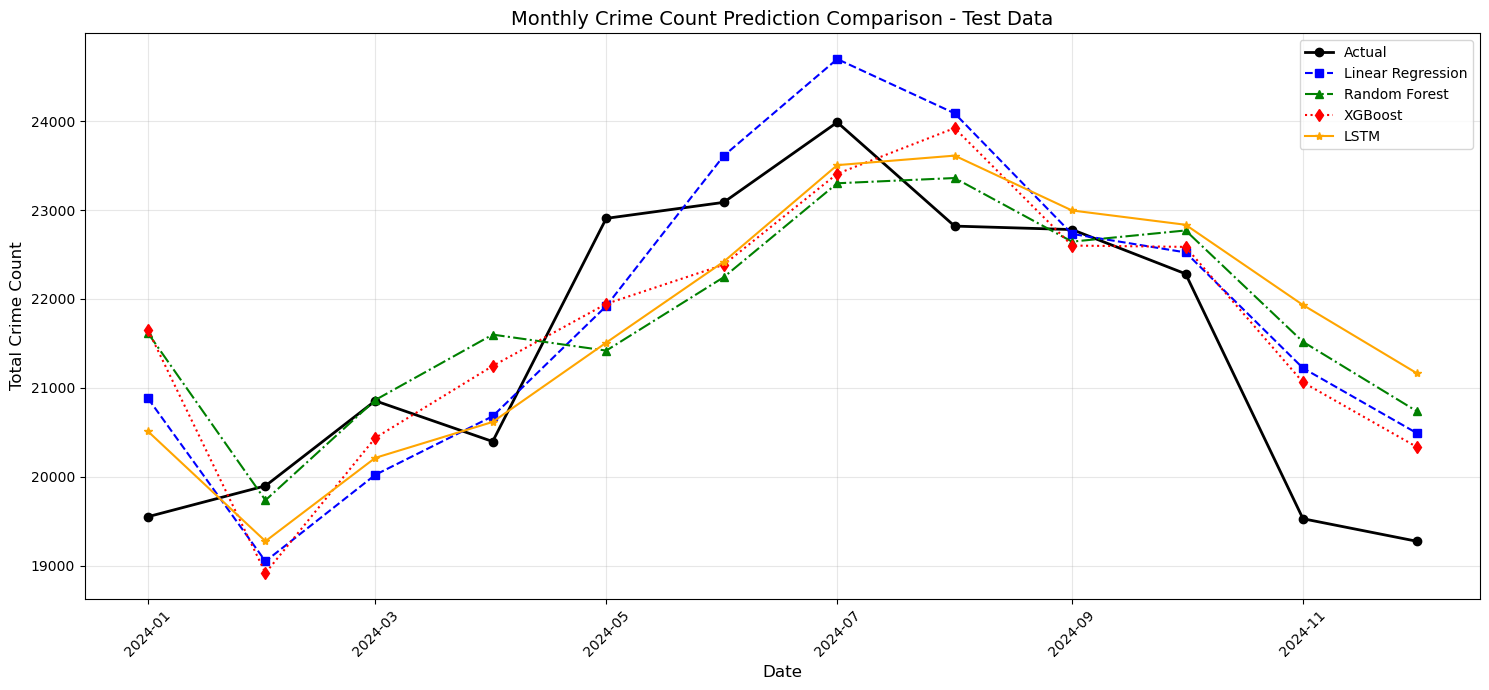

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. MONTHLY AGGREGATION PLOTS
# ============================

# Aggregate by month
monthly_train = (
    df_train_result.groupby(["Year", "Month"])
    .agg(
        {
            "crime_count": "sum",
            "lr_pred": "sum",
            "rf_pred": "sum",
            "xg_pred": "sum",
            "lstm_pred": "sum",
        }
    )
    .reset_index()
)

monthly_test = (
    df_test_result.groupby(["Year", "Month"])
    .agg(
        {
            "crime_count": "sum",
            "lr_pred": "sum",
            "rf_pred": "sum",
            "xg_pred": "sum",
            "lstm_pred": "sum",
        }
    )
    .reset_index()
)

# Create date columns
monthly_train["date"] = pd.to_datetime(
    monthly_train["Year"].astype(str) + "-" + monthly_train["Month"].astype(str) + "-01"
)
monthly_test["date"] = pd.to_datetime(
    monthly_test["Year"].astype(str) + "-" + monthly_test["Month"].astype(str) + "-01"
)

# Sort by date
monthly_train = monthly_train.sort_values("date")
monthly_test = monthly_test.sort_values("date")

y_test_monthly = monthly_test["crime_count"]
# Plot monthly comparison - Training data
plt.figure(figsize=(15, 7))
plt.plot(
    monthly_train["date"],
    monthly_train["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_train["date"],
    monthly_train["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
plt.plot(
    monthly_train["date"],
    monthly_train["rf_pred"],
    marker="^",
    linestyle="-.",
    label="Random Forest",
    color="green",
)
plt.plot(
    monthly_train["date"],
    monthly_train["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.plot(
    monthly_train["date"],
    monthly_train["lstm_pred"],
    marker="*",
    linestyle="-",
    label="LSTM",
    color="orange",
)
plt.title("Monthly Crime Count Prediction Comparison - Training Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_comparison_train_data.pdf", format="pdf")
plt.show()

# Plot monthly comparison - Test data
plt.figure(figsize=(15, 7))
plt.plot(
    monthly_test["date"],
    monthly_test["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
plt.plot(
    monthly_test["date"],
    monthly_test["rf_pred"],
    marker="^",
    linestyle="-.",
    label="Random Forest",
    color="green",
)
plt.plot(
    monthly_test["date"],
    monthly_test["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lstm_pred"],
    marker="*",
    linestyle="-",
    label="LSTM",
    color="orange",
)
plt.title("Monthly Crime Count Prediction Comparison - Test Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_comparison_test_data.pdf", format="pdf")
plt.show()

In [82]:
for m in ["lr", "rf", "xg", "lstm"]:
    rmse, mae, r2, mae_percentage = summarize_results(monthly_test, f"{m}_pred")
    print(f"Model: {m}")
    print(f"RMSE\tR²\tMAE\tMAE Percentage")
    print(f"{rmse:.2f}\t{r2:.2f}\t{mae:.2f}\t{mae_percentage:.2f}%")
    print("\n")

Model: lr
RMSE	R²	MAE	MAE Percentage
959.44	0.65	832.50	3.88%


Model: rf
RMSE	R²	MAE	MAE Percentage
1146.94	0.50	922.92	4.30%


Model: xg
RMSE	R²	MAE	MAE Percentage
1034.53	0.59	897.75	4.19%


Model: lstm
RMSE	R²	MAE	MAE Percentage
1108.48	0.53	904.08	4.22%




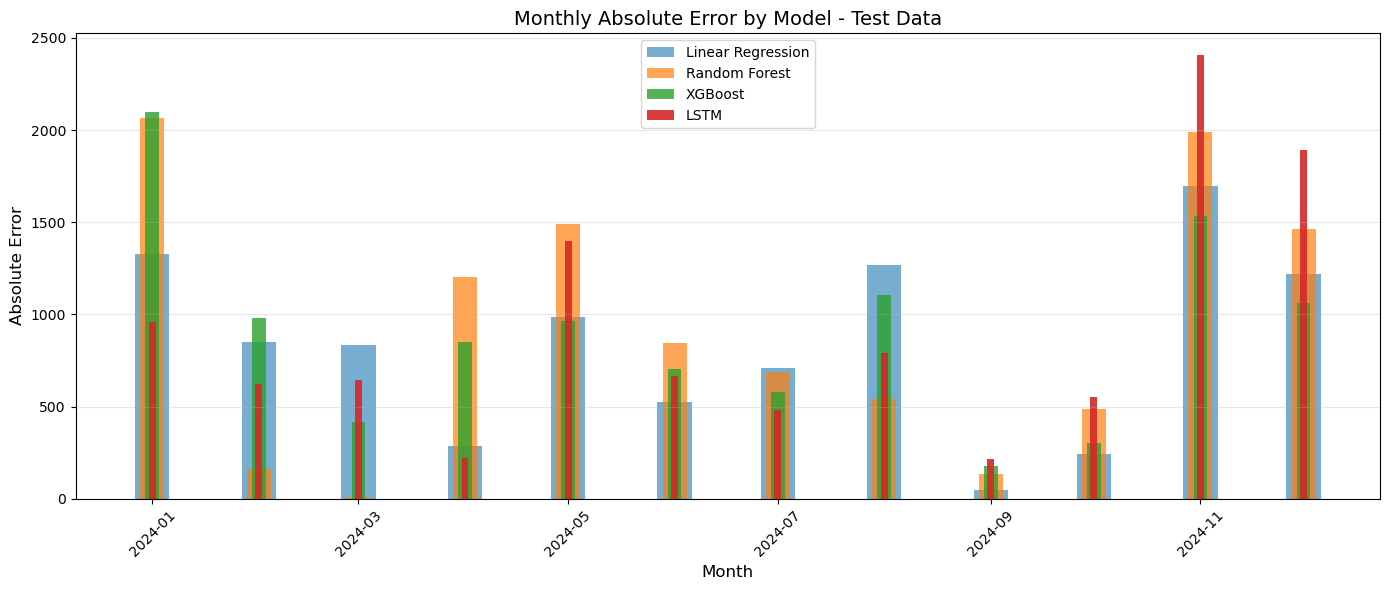

In [83]:
# 2. MODEL PERFORMANCE BY MONTH
# ============================

# Calculate monthly MAE for each model (test data)
monthly_test["lr_mae"] = abs(monthly_test["crime_count"] - monthly_test["lr_pred"])
monthly_test["rf_mae"] = abs(monthly_test["crime_count"] - monthly_test["rf_pred"])
monthly_test["xg_mae"] = abs(monthly_test["crime_count"] - monthly_test["xg_pred"])
monthly_test["lstm_mae"] = abs(monthly_test["crime_count"] - monthly_test["lstm_pred"])

# Plot MAE by month
plt.figure(figsize=(14, 6))
plt.bar(
    monthly_test["date"],
    monthly_test["lr_mae"],
    width=10,
    alpha=0.6,
    label="Linear Regression",
)
plt.bar(
    monthly_test["date"],
    monthly_test["rf_mae"],
    width=7,
    alpha=0.7,
    label="Random Forest",
)
plt.bar(
    monthly_test["date"], monthly_test["xg_mae"], width=4, alpha=0.8, label="XGBoost"
)
plt.bar(
    monthly_test["date"],
    monthly_test["lstm_mae"],
    width=2,
    alpha=0.9,
    label="LSTM",
)
plt.title("Monthly Absolute Error by Model - Test Data", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Absolute Error", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_absolute_error_by_model_test_data.pdf", format="pdf")
plt.show()

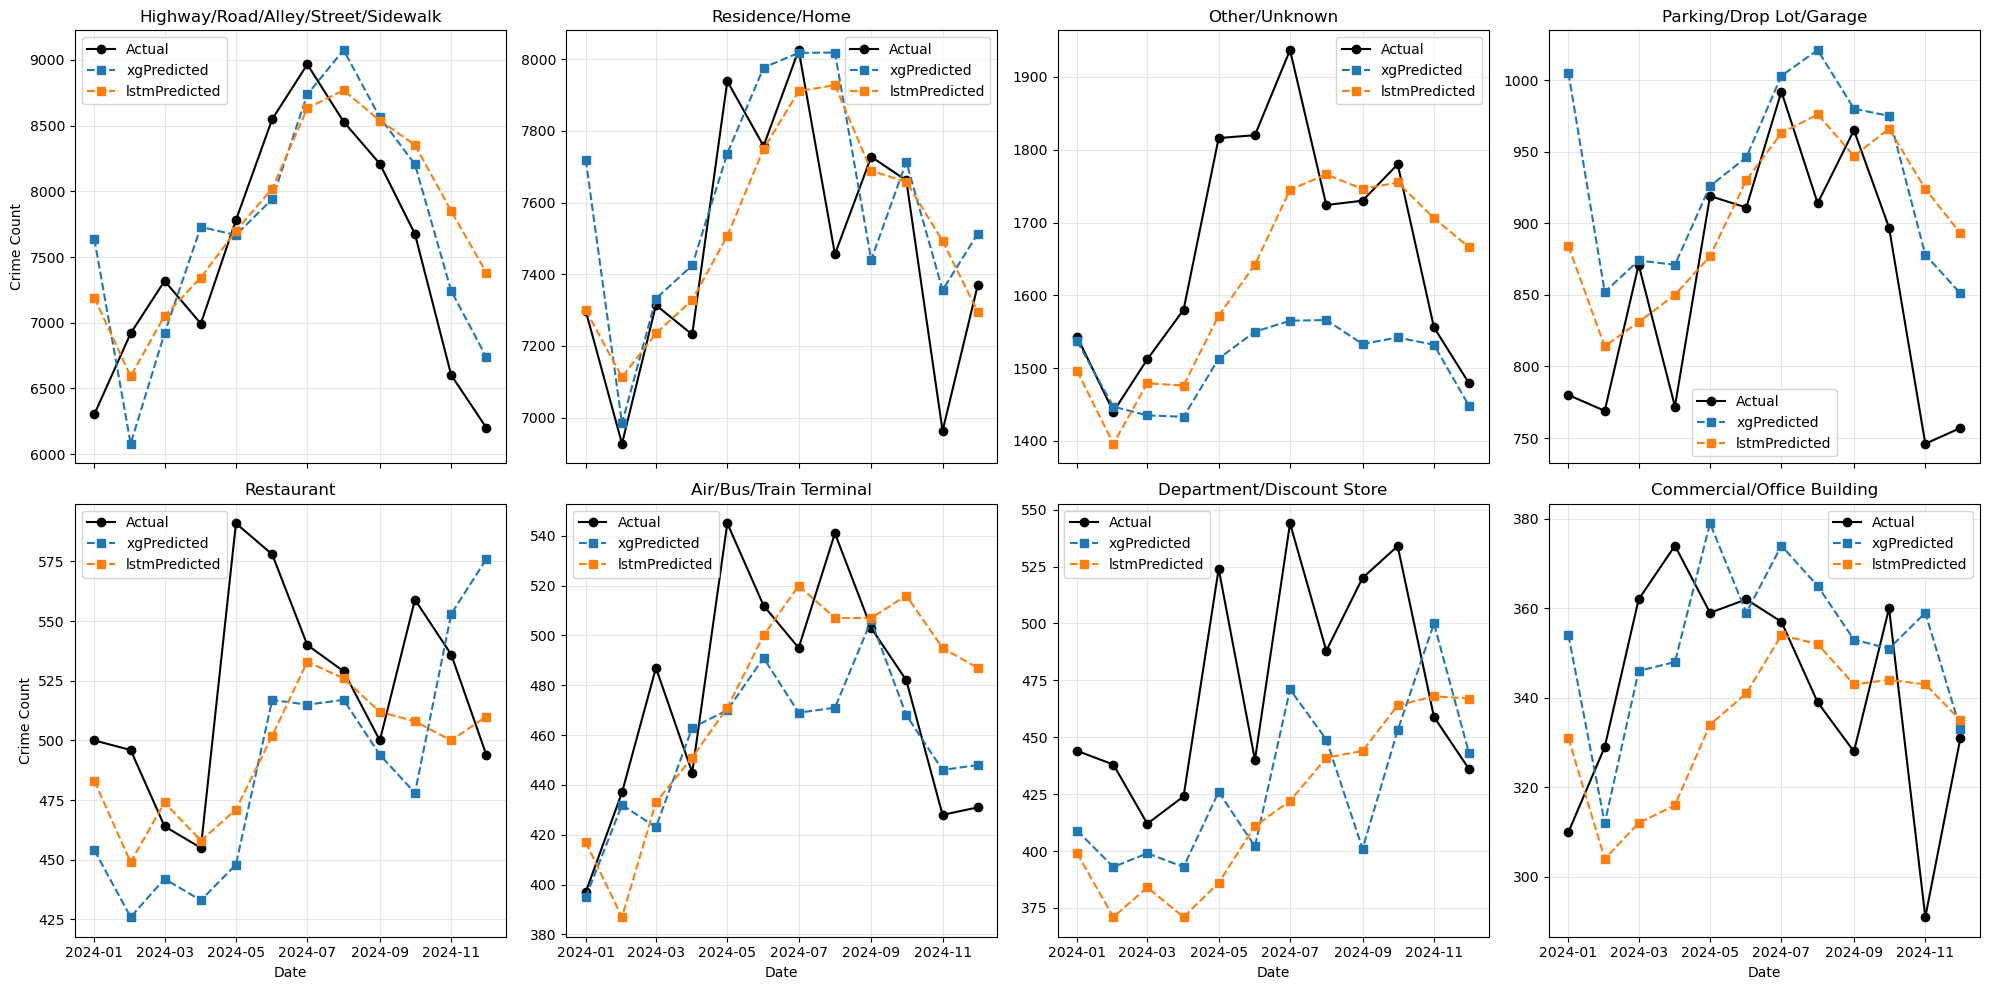

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Identify the top 8 locations by total crime count
top8_locations = (
    df_test_result.groupby("location_name")["crime_count"]
    .sum()
    .nlargest(8)
    .index.tolist()
)

# 2. Filter data for these top 8 locations
df_top8 = df_test_result[df_test_result["location_name"].isin(top8_locations)].copy()

# 3. Aggregate monthly data (summing the actual and predicted counts)
df_trend = df_top8.groupby(["location_name", "Year", "Month"], as_index=False).agg(
    crime_count=("crime_count", "sum"),
    rf_pred=("rf_pred", "sum"),
    xg_pred=("xg_pred", "sum"),
    lr_pred=("lr_pred", "sum"),
    lstm_pred=("lstm_pred", "sum"),
)

# 4. Create a datetime column for proper time series plotting (using the 1st day of each month)
df_trend["Date"] = pd.to_datetime(
    df_trend["Year"].astype(str) + "-" + df_trend["Month"].astype(str) + "-01"
)

# 5. Plotting in subplots (2 rows x 4 columns for 8 subplots) without sharing the y-axis
fig, axes = plt.subplots(
    nrows=2, ncols=4, figsize=(20, 10), sharex=True
)  # Remove sharey to allow independent y-axis
axes = axes.flatten()  # Flatten to iterate easily

for i, loc in enumerate(top8_locations):
    ax = axes[i]
    df_loc = df_trend[df_trend["location_name"] == loc].sort_values("Date")

    # Plot actual crime count
    ax.plot(
        df_loc["Date"],
        df_loc["crime_count"],
        marker="o",
        linestyle="-",
        label="Actual",
        color="black",
    )
    # Plot predicted crime count
    for m in ["xg", "lstm"]:
        ax.plot(
            df_loc["Date"],
            df_loc[f"{m}_pred"],
            marker="s",
            linestyle="--",
            label=f"{m}Predicted",
        )

    ax.set_title(loc)
    ax.grid(True, alpha=0.3)

    # Set labels for the leftmost and bottom plots only
    if i % 4 == 0:  # Leftmost plots
        ax.set_ylabel("Crime Count")
    if i >= 4:  # Bottom row plots
        ax.set_xlabel("Date")

    ax.legend()

# Remove any unused subplots (if there are fewer than 8, not applicable here)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("./figure/monthly_crime_trends_top8_locations_test_data.pdf", format="pdf")
plt.show()

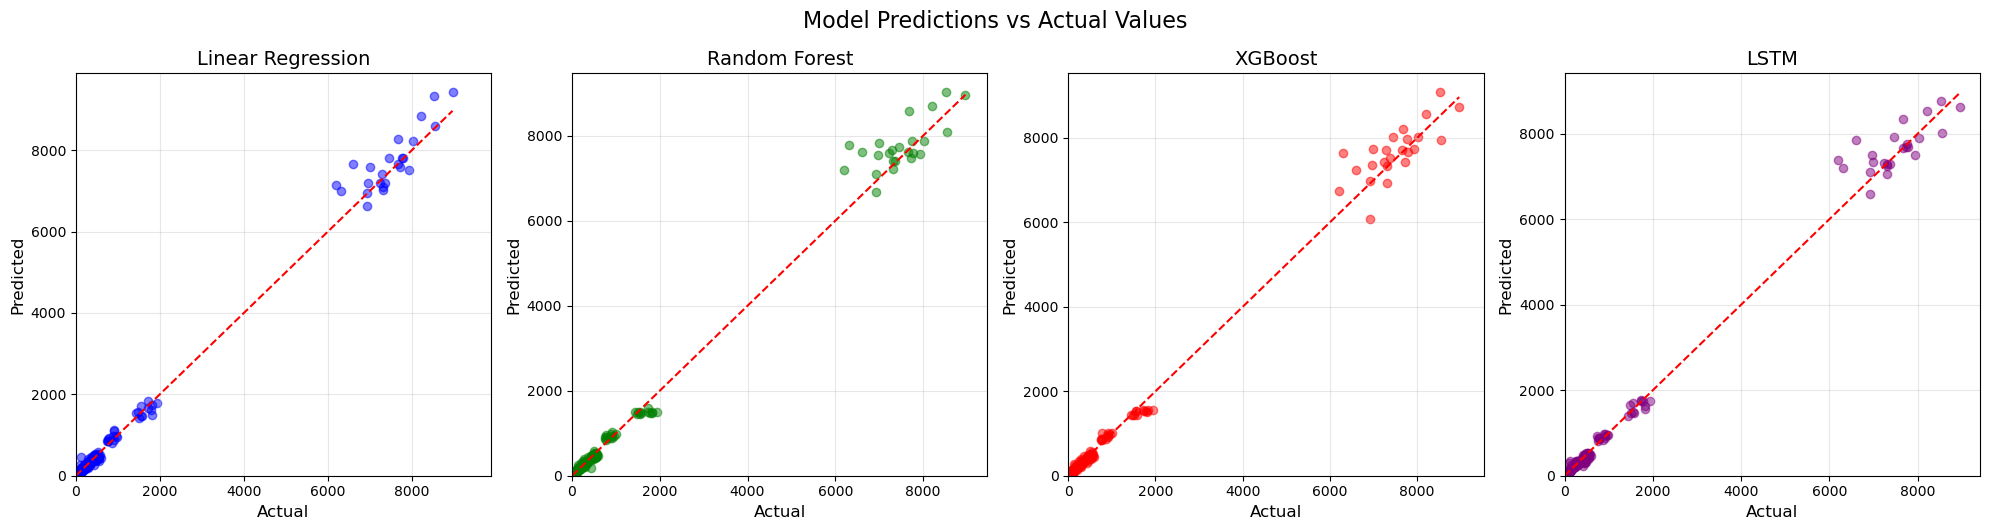

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 4 subplots (for LR, RF, XGBoost, and LSTM)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Define models, colors, and titles
models = ["lr_pred", "rf_pred", "xg_pred", "lstm_pred"]
colors = ["blue", "green", "red", "purple"]
titles = ["Linear Regression", "Random Forest", "XGBoost", "LSTM"]

# Loop through each model and create scatter plot
for i, (model, color, title) in enumerate(zip(models, colors, titles)):
    # Create scatter plot
    axes[i].scatter(
        df_test_result["crime_count"], df_test_result[model], alpha=0.5, color=color
    )

    # Add diagonal line for perfect predictions
    axes[i].plot(
        [0, df_test_result["crime_count"].max()],
        [0, df_test_result["crime_count"].max()],
        "r--",
    )

    # Add title and labels
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel("Actual", fontsize=12)
    axes[i].set_ylabel("Predicted", fontsize=12)
    axes[i].grid(True, alpha=0.3)

    # Optional: Set the same limits for all plots for easier comparison
    max_val = max(df_test_result["crime_count"].max(), df_test_result[model].max())
    axes[i].set_xlim(0, max_val * 1.05)
    axes[i].set_ylim(0, max_val * 1.05)

# Adjust layout
plt.tight_layout()
plt.suptitle("Model Predictions vs Actual Values", fontsize=16, y=1.05)
plt.savefig("./figure/model_predictions_vs_actual_values_test_data.pdf", format="pdf")
plt.show()

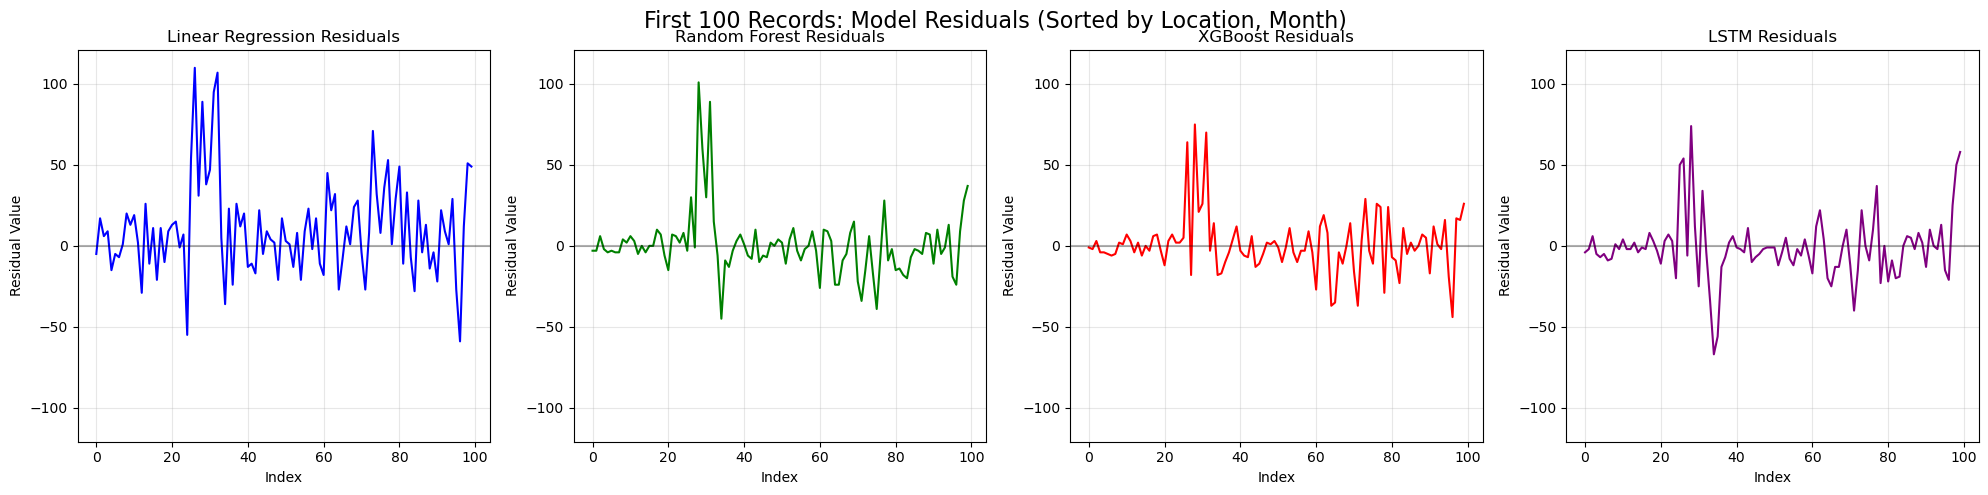

In [86]:
import matplotlib.pyplot as plt

# Create a figure with 4 subplots (for LR, RF, XGBoost, and LSTM)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Sort dataframe by location and time
sorted_df = df_test_result.sort_values(["location_name", "Month"]).reset_index(
    drop=True
)

# Define models, colors, titles, and line styles
models = ["lr_res", "rf_res", "xg_res", "lstm_res"]
colors = ["blue", "green", "red", "purple"]
titles = [
    "Linear Regression Residuals",
    "Random Forest Residuals",
    "XGBoost Residuals",
    "LSTM Residuals",
]
line_styles = ["-", "-", "-", "-"]

# Loop through each model and create residual plot
for i, (model, color, title, ls) in enumerate(zip(models, colors, titles, line_styles)):
    # Plot residuals for first 100 records
    axes[i].plot(
        sorted_df.index[:100],
        sorted_df[model][:100],
        marker="",
        linestyle=ls,
        color=color,
    )

    # Add title and labels
    axes[i].set_title(title)
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel("Residual Value")
    axes[i].grid(True, alpha=0.3)

    # Optional: Add a horizontal line at y=0 to show the zero residual line
    axes[i].axhline(y=0, color="black", linestyle="-", alpha=0.3)

    # Optional: Set consistent y-axis limits for all plots
    max_res = max([abs(sorted_df[m][:100]).max() for m in models])
    axes[i].set_ylim(-max_res * 1.1, max_res * 1.1)

# Add a main title to the figure
fig.suptitle(
    "First 100 Records: Model Residuals (Sorted by Location, Month)", fontsize=16
)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for the suptitle
plt.show()